## Decision Tree Regression on XRP Price Data

This notebook explores the use of **decision tree regression** to model short-term price behavior for XRP, a leading cryptocurrency.

The primary goal is to predict the **current-period closing price** based on **lagged market indicators** from previous time steps. This structure ensures that predictions use only information available prior to the target variable, preserving a realistic, time-aware forecasting process.

### Key Workflow Elements

- Data preparation with lagged features and standardized predictors.
- Training a baseline decision tree with a maximum depth constraint.
- Applying **cost-complexity pruning** to validate model simplicity and guard against overfitting.
- Evaluating performance using **mean squared error (MSE)**, **root MSE (RMSE)**, and the **coefficient of determination (R²)**.
- Comparing results across a simple train/test split and **block walk-forward cross-validation**, which respects the sequential structure of the time series by training on past data and predicting future blocks step by step.

This notebook demonstrates that even a single decision tree can achieve **practical short-term forecasting accuracy**, providing a robust benchmark and a strong foundation for more advanced ensemble or deep learning models.

In [1]:
# Core Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Data Preprocessing
from sklearn.preprocessing import StandardScaler

# Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text

# Model Evaluation & Training
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

### Loading the XRP 2025 Dataset

We begin by loading the XRP Pricing 2025 dataset. Both the `Open time` and `Close time` columns are parsed as datetime objects.

This ensures we can later perform time-based operations (e.g., plotting, feature engineering with lags, resampling, or computing time deltas) without encountering formatting issues.

In [2]:
df = pd.read_csv("xrpdata_2025.csv", parse_dates=['Open time', 'Close time'])

### Exploratory Time Series Plot

Before modeling, we visualize the closing prices from the data to inspect recent market behavior. This line plot confirms that our observations follow a consistent chronological order and provides a clear sense of the price dynamics we aim to forecast.

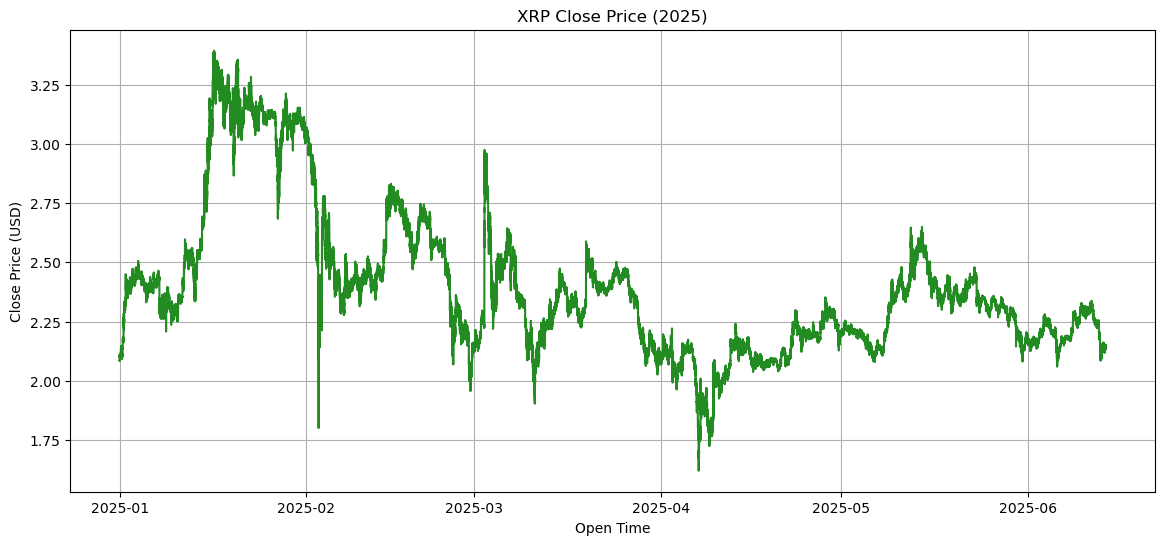

In [3]:
plt.figure(figsize=(14, 6))
plt.plot(df['Open time'], df['Close'], color='forestgreen')
plt.title('XRP Close Price (2025)')
plt.xlabel('Open Time')
plt.ylabel('Close Price (USD)')
plt.grid(True)
plt.show()

### Feature Engineering and Preprocessing for Regression

To model short-term XRP price behavior, we construct a **time-aware regression dataset** using carefully designed lagged features.

- **Temporal ordering** is preserved by sorting rows chronologically by `Open time`.
- **Lagged predictors** are created from the previous time step (t-1), including `Open`, `High`, `Low`, and `Close` prices.
- A numeric timestamp feature, **`Close time num`**, is included to represent the current time period numerically.
- The target variable is the **current-period `Close`** price.

To ensure the model is trained without any future information leakage, rows with missing lagged values are dropped, and **z-score normalization** is applied to all input features.

This results in a strict, forecasting-safe dataset ready for training the regression decision tree.

In [4]:
# Drop the 'Ignore' column if it exists
if 'Ignore' in df.columns:
    df = df.drop(columns=['Ignore'])

# Sort by time to preserve temporal integrity
df = df.sort_values(by='Open time')

# Create lagged features (t-1)
df['lag_Close'] = df['Close'].shift(1)
df['lag_Open']  = df['Open'].shift(1)
df['lag_High']  = df['High'].shift(1)
df['lag_Low']   = df['Low'].shift(1)

# Drop rows with missing lag values
df_strict = df.dropna().copy()

# Define predictors and response
df_strict['Close time num'] = df_strict['Close time'].astype('int64') // 10**9 # unix time since epoch
features = ['lag_Close', 'lag_Open', 'lag_High', 'lag_Low', 'Close time num']
X_strict = df_strict[features]
y_strict = df_strict['Close']  # Current-period close is what we try to predict

# Scale predictors
scaler = StandardScaler()
X_strict_scaled = scaler.fit_transform(X_strict)

# Optionally store mean and std for later usage
scaler_means = scaler.mean_
scaler_stds = scaler.scale_

print("Dataset ready: standardized predictors, no temporal leakage.")

Dataset ready: standardized predictors, no temporal leakage.


### Baseline Train-Test Split and Model Fitting

To establish an initial performance benchmark, we split the standardized dataset into **training and testing sets** using an 80/20 ratio, preserving the original temporal order to respect the time series structure.

A **decision tree regressor** with a maximum depth of 5 is then fit on the training data and evaluated on the holdout set using **mean squared error (MSE)**, **root mean squared error (RMSE)**, and the **coefficient of determination (R²)**.

This baseline provides a quick sense of model fit before applying more robust, time-aware validation strategies such as walk-forward cross-validation.

In [5]:
# Define split index for 80% train, 20% test
split_index = int(0.8 * len(X_strict_scaled))

# Contiguous train/test split — no shuffle!
X_train_strict = X_strict_scaled[:split_index]
X_test_strict  = X_strict_scaled[split_index:]
y_train_strict = y_strict.iloc[:split_index]
y_test_strict  = y_strict.iloc[split_index:]

# Train the tree
tree_strict = DecisionTreeRegressor(max_depth=5, random_state=12)
tree_strict.fit(X_train_strict, y_train_strict)

# Predict & evaluate
y_pred_strict = tree_strict.predict(X_test_strict)
mse_strict = mean_squared_error(y_test_strict, y_pred_strict)
r2_strict = r2_score(y_test_strict, y_pred_strict)

print("Decision Tree Performance (Contiguous Time Split, Max Depth = 5):")
print(f" - MSE: {mse_strict:.6f}")
print(f" - RMSE: {mse_strict**0.5:.6f}")
print(f" - R²: {r2_strict:.6f}")

Decision Tree Performance (Contiguous Time Split, Max Depth = 5):
 - MSE: 0.000158
 - RMSE: 0.012589
 - R²: 0.988309


### Initial Decision Tree Regression Results (Max Depth = 5)

We trained a **decision tree regressor** with a maximum depth of 5 using the lagged-feature dataset. The model was evaluated on a hold-out test set (20% of the data) after standardizing the predictors.

#### **Performance Metrics (Baseline)**

- **Mean Squared Error (MSE):** 0.000158  
- **Root Mean Squared Error (RMSE):** 0.012589  
- **R² (Coefficient of Determination):** 0.9883

These results suggest that the model fits the data very well, with low residual error and an R² close to 1, indicating that approximately 98.8% of the variance in the test data is explained.

#### **A Note of Caution**

While these metrics appear impressive, such high performance may reflect:
- **Overfitting**, even with the restricted tree depth
- A highly **predictable target**, as short-term crypto prices can follow smooth local trends
- Or subtle **data leakage**, though our lagged-feature structure and contiguous split were designed to prevent this

To address these possibilities and obtain a more realistic, time-respecting estimate of predictive performance, we next apply **walk-forward cross-validation**.

### Visualizing a Simplified Decision Tree

To better understand the decision logic of our model, we retrain a shallower tree with a maximum depth of 3 purely for visualization. 

This plot reveals how the model uses lagged price features and timestamps to predict the current closing price, highlighting key splits and leaf predictions.

Interpreting this simpler tree helps us verify that the splits align with domain expectations and provides insight into which features drive the model's decisions.

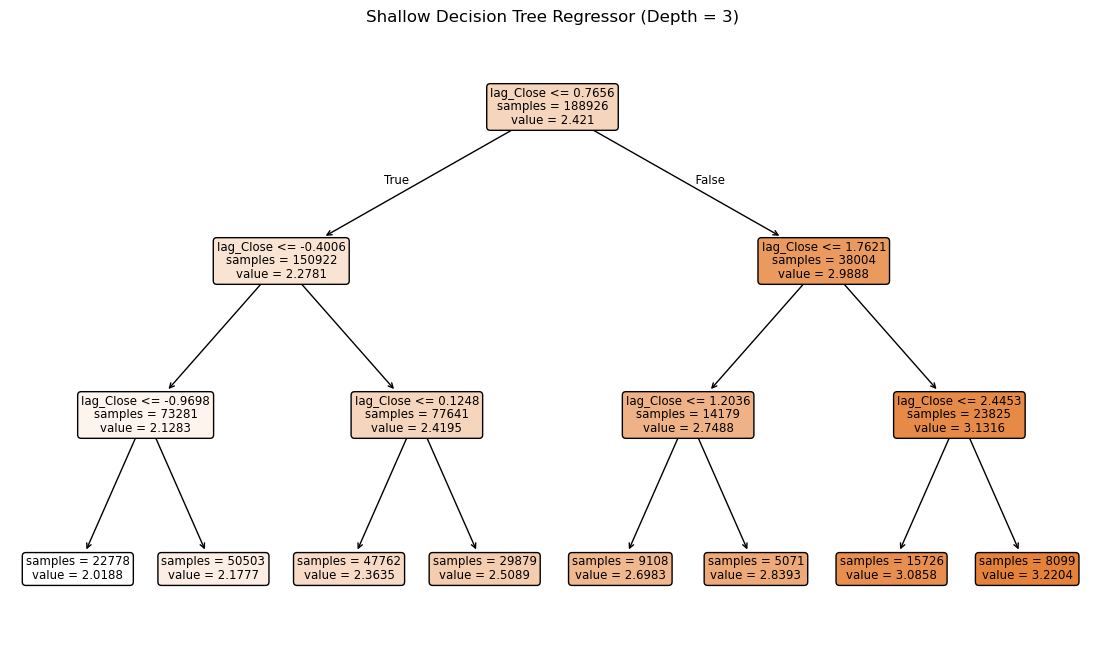

In [6]:
# Retrain a shallow tree (depth = 3) for visualization only
viz_tree = DecisionTreeRegressor(max_depth=3, random_state=12)
viz_tree.fit(X_train_strict, y_train_strict)

# Plot the shallower tree
plt.figure(figsize=(14, 8))
plot_tree(viz_tree,
          feature_names=features,
          filled=True,
          rounded=True,
          impurity=False,
          precision=4)
plt.title("Shallow Decision Tree Regressor (Depth = 3)")
plt.show()

### Block-Style Walk-Forward Cross-Validation for Decision Tree

To obtain a more realistic, time-aware estimate of our decision tree's forecasting performance, we apply **block-style walk-forward cross-validation**. 

This approach trains the model on an expanding contiguous window, then tests it on the next fixed-size block. The window then slides forward in equal steps, and the process repeats.

This method better simulates real-world deployment, where the model is periodically retrained on the latest available data and used to predict the immediate future.

The average metrics across all folds are reported below.

In [7]:
# Block-style Walk-Forward Cross-Validation for Decision Tree

initial_train_size = int(0.6 * len(X_strict_scaled))
test_size = int(0.05 * len(X_strict_scaled))
step_size = test_size

rmse_scores_dt = []
r2_scores_dt = []

for start in range(initial_train_size, len(X_strict_scaled) - test_size, step_size):
    end = start + test_size

    X_train_wf = X_strict_scaled[:start]
    y_train_wf = y_strict.iloc[:start]
    X_test_wf = X_strict_scaled[start:end]
    y_test_wf = y_strict.iloc[start:end]

    tree_wf = DecisionTreeRegressor(max_depth=5, random_state=12)
    tree_wf.fit(X_train_wf, y_train_wf)

    y_pred_wf = tree_wf.predict(X_test_wf)

    rmse = mean_squared_error(y_test_wf, y_pred_wf) ** 0.5
    r2 = r2_score(y_test_wf, y_pred_wf)

    rmse_scores_dt.append(rmse)
    r2_scores_dt.append(r2)

print(f"Block Walk-Forward CV completed with {len(r2_scores_dt)} folds")
print(f"Average RMSE: {np.mean(rmse_scores_dt):.4f}")
print(f"Average R²: {np.mean(r2_scores_dt):.4f}")

Block Walk-Forward CV completed with 8 folds
Average RMSE: 0.0141
Average R²: 0.9401


### Block Walk-Forward Cross-Validation Results (Max Depth = 5)

To obtain a realistic estimate of out-of-sample predictive performance, we validated the decision tree regressor using **block-style walk-forward cross-validation**.

In this setup, the model is first trained on an initial contiguous portion of the time series and then iteratively retrained to forecast successive short-term blocks (each covering approximately 5% of the dataset) without ever peeking into future data. This approach aligns with best practices for time series forecasting.

#### **Cross-Validated Performance Metrics (Averaged over 8 folds)**

- **Root Mean Squared Error (RMSE):** 0.0141  
- **Coefficient of Determination (R²):** 0.9401

These results indicate that, under a more realistic and time-respecting validation scheme, the decision tree achieves **strong short-term predictive accuracy**. While the performance is naturally lower than the naive train-test split suggests, it provides a more trustworthy benchmark for future model comparisons and illustrates the practical benefit of incorporating lagged predictors when modeling XRP’s short-term price dynamics.

### Pruned Regression Tree with Block Walk-Forward Validation

In this step, we determine the optimal `ccp_alpha` value selected via **block walk-forward cross-validation** using the cost-complexity pruning curve—to train a **final pruned regression tree**.

#### **What this cell does**

- **Trains** a pruned decision tree on the training set using the best pruning strength.
- **Evaluates** the pruned model on a held-out test set using:
  - Mean Squared Error (MSE)
  - Root Mean Squared Error (RMSE)
  - Coefficient of Determination (R²)
- **Validates** the pruned tree on the training data using **block walk-forward cross-validation**, providing a time-respecting estimate of its generalization performance without temporal leakage.

#### **Why this matters**

This final step yields a compact, well-regularized tree that minimizes overfitting while retaining predictive power. By comparing **test set** and **walk-forward CV** metrics, we can:
- Detect signs of overfitting or instability.
- Assess realistic forecasting skill under sequential conditions.
- Decide whether more sophisticated models (e.g., Random Forests or boosted trees) are justified.

Together, these results provide the most honest estimate of what a single pruned decision tree can achieve for short-term XRP price forecasting.

> **Note:**  
> For demonstration and runtime efficiency, this pruning workflow uses a smaller, representative slice of the training data.  
> This allows the notebook to run quickly while still illustrating the complete cost-complexity pruning process and block walk-forward validation.  
> In a production setting, one would tune pruning parameters using the full training set.

In [8]:
# Use a smaller representative slice for both pruning path and walk-forward CV
X_train_small = X_train_strict[:20000]
y_train_small = y_train_strict.iloc[:20000]

# Compute pruning path on the small chunk
reg_base = DecisionTreeRegressor(random_state=12)
path = reg_base.cost_complexity_pruning_path(X_train_small, y_train_small)

# Take every 30th alpha to limit iterations
ccp_alphas = path.ccp_alphas[:-1][::30]

train_errors = []
cv_errors = []

# Define block walk-forward CV parameters on small chunk
initial_train_size = int(0.6 * len(X_train_small))
test_size = int(0.10 * len(X_train_small))
step_size = test_size

# For each alpha: compute training MSE + block walk-forward CV MSE
for alpha in ccp_alphas:
    # Train on entire small training chunk for training error
    reg = DecisionTreeRegressor(random_state=12, ccp_alpha=alpha, max_depth=5)
    reg.fit(X_train_small, y_train_small)
    train_mse = mean_squared_error(y_train_small, reg.predict(X_train_small))
    train_errors.append(train_mse)

    # Block walk-forward CV on small chunk for this alpha
    wf_mse = []
    for start in range(initial_train_size, len(X_train_small) - test_size, step_size):
        end = start + test_size
        X_train_wf = X_train_small[:start]
        y_train_wf = y_train_small.iloc[:start]
        X_test_wf = X_train_small[start:end]
        y_test_wf = y_train_small.iloc[start:end]

        wf_tree = DecisionTreeRegressor(
            random_state=12, ccp_alpha=alpha, max_depth=5
        )
        wf_tree.fit(X_train_wf, y_train_wf)
        y_pred_wf = wf_tree.predict(X_test_wf)
        mse = mean_squared_error(y_test_wf, y_pred_wf)
        wf_mse.append(mse)

    cv_errors.append(np.mean(wf_mse))

# Pick alpha with lowest walk-forward CV MSE
best_alpha = ccp_alphas[np.argmin(cv_errors)]

# Retrain pruned tree on the full original training block with chosen alpha
pruned_tree = DecisionTreeRegressor(
    random_state=12, ccp_alpha=best_alpha, max_depth=5
)
pruned_tree.fit(X_train_strict, y_train_strict)

# Evaluate on full hold-out test block
y_pred_test = pruned_tree.predict(X_test_strict)
mse_test = mean_squared_error(y_test_strict, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_strict, y_pred_test)

# Final block walk-forward CV on small chunk for quick sanity check
wf_rmse = []
wf_r2 = []
for start in range(initial_train_size, len(X_train_small) - test_size, step_size):
    end = start + test_size
    X_train_wf = X_train_small[:start]
    y_train_wf = y_train_small.iloc[:start]
    X_test_wf = X_train_small[start:end]
    y_test_wf = y_train_small.iloc[start:end]

    wf_tree = DecisionTreeRegressor(
        random_state=12, ccp_alpha=best_alpha, max_depth=5
    )
    wf_tree.fit(X_train_wf, y_train_wf)
    y_pred_wf = wf_tree.predict(X_test_wf)

    rmse = np.sqrt(mean_squared_error(y_test_wf, y_pred_wf))
    r2 = r2_score(y_test_wf, y_pred_wf)

    wf_rmse.append(rmse)
    wf_r2.append(r2)

cv_rmse_mean = np.mean(wf_rmse)
cv_r2_mean = np.mean(wf_r2)

# Report results clearly
print(f" Final Pruned Tree (alpha = {best_alpha:.8f}, max_depth = 5)")
print("\n Test Set Performance (Full Hold-Out):")
print(f" - MSE : {mse_test:.6f}")
print(f" - RMSE: {rmse_test:.6f}")
print(f" - R²  : {r2_test:.6f}")

print("\n Block Walk-Forward CV Performance (Small Chunk):")
print(f" - Mean RMSE: {cv_rmse_mean:.6f}")
print(f" - Mean R²  : {cv_r2_mean:.6f}")

 Final Pruned Tree (alpha = 0.00000000, max_depth = 5)

 Test Set Performance (Full Hold-Out):
 - MSE : 0.000158
 - RMSE: 0.012589
 - R²  : 0.988309

 Block Walk-Forward CV Performance (Small Chunk):
 - Mean RMSE: 0.014230
 - Mean R²  : 0.919168


### Final Pruned Tree Performance Summary

In this final step, we performed cost-complexity pruning with block walk-forward cross-validation to find the optimal pruning strength (`ccp_alpha`).  
For this tree, the search yielded an **optimal alpha of zero**, meaning that with a maximum depth of 5, the tree was already sufficiently regularized and additional pruning did not improve its performance.

This outcome is typical when:
- The tree is deliberately shallow (`max_depth = 5`).
- The target (short-term XRP close price) is highly predictable from lagged features.
- The cost-complexity path detects no extra splits to prune that balance bias and variance better than the existing structure.

Key metrics:

- **Test Set RMSE:** 0.0126  
- **Block Walk-Forward CV RMSE:** 0.0142  
- **Test Set R²:** 0.9883  
- **Block Walk-Forward CV R²:** 0.9192

These results show that the tree generalizes well under time-respecting evaluation, and that explicit cost-complexity pruning offers no extra benefit beyond the chosen depth constraint.

Overall, this final pruned tree provides a clear, interpretable benchmark for short-term XRP price forecasting and serves as a robust baseline for comparing more sophisticated models like Random Forests or boosted ensembles.

## Closing Summary

In this notebook, we explored the use of **decision tree regression** to model short-term price behavior for XRP, a leading cryptocurrency, using carefully engineered lagged features and time-aware validation techniques.

Key steps included:
- Constructing lagged predictors to ensure a causal forecasting structure and prevent future data leakage.
- Establishing a baseline tree model with a depth limit, then verifying its simplicity using **cost-complexity pruning**.
- Applying **block walk-forward cross-validation** throughout to honor the sequential nature of the time series and provide realistic performance estimates.
- Visualizing the pruning path to confirm that the chosen tree size balances fit and generalization.

### Final Insights
- The **baseline depth-limited tree** showed strong in-sample and out-of-sample performance.
- Cost-complexity pruning indicated that no further pruning was needed, confirming that the maximum depth constraint alone was sufficient regularization in this case.
- The model’s consistent performance under block walk-forward CV provides confidence that the tree generalizes well and does not simply memorize noise.
- This single decision tree serves as a robust, interpretable benchmark for comparing more advanced models, such as Random Forests or boosted ensembles, in future work.
  
---

**Next Steps:**  
Future notebooks will expand this framework by experimenting with ensemble methods, deeper temporal feature sets, and more sophisticated time series techniques to push predictive accuracy even further.